# Human Activity Recognition System
## Classical ML vs Deep Learning (Reproducible Colab Notebook)

This notebook fixes path issues and broken variables, and provides a clean end‑to‑end pipeline.


In [ ]:
# ===== 0) Setup & Reproducibility =====
!pip -q install kagglehub opencv-python tqdm scikit-learn pandas matplotlib seaborn tensorflow

import os, random, json
from pathlib import Path
import numpy as np
import pandas as pd

SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)
print("Seed set to", SEED)


Seed set to 42


## 1) Dataset Setup (Works in Colab)

We use `kagglehub` to download the dataset. Then we *auto-detect* where `train.csv`, `val.csv`, `test.csv`, and the video folder are located so you do not need Kaggle's `/kaggle/input/...` path.


In [ ]:
import kagglehub

# Download latest version of the dataset
DATASET_ROOT = Path(kagglehub.dataset_download("matthewjansen/ucf101-action-recognition"))
print("Downloaded dataset root:", DATASET_ROOT)

def find_one(root: Path, filename: str) -> Path:
    matches = list(root.rglob(filename))
    if not matches:
        raise FileNotFoundError(f"Could not find {filename} under {root}")
    # choose shortest path (usually the real one, not a duplicate)
    return sorted(matches, key=lambda p: len(str(p)))[0]

TRAIN_CSV = find_one(DATASET_ROOT, "train.csv")
VAL_CSV   = find_one(DATASET_ROOT, "val.csv")
TEST_CSV  = find_one(DATASET_ROOT, "test.csv")

print("train.csv:", TRAIN_CSV)
print("val.csv:", VAL_CSV)
print("test.csv:", TEST_CSV)

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train shape:", train_df.shape)
display(train_df.head())


Using Colab cache for faster access to the 'ucf101-action-recognition' dataset.
Downloaded dataset root: /kaggle/input/ucf101-action-recognition
train.csv: /kaggle/input/ucf101-action-recognition/train.csv
val.csv: /kaggle/input/ucf101-action-recognition/val.csv
test.csv: /kaggle/input/ucf101-action-recognition/test.csv
Train shape: (10055, 3)


,clip_name,clip_path,label
0,v_Swing_g05_c02,/train/Swing/v_Swing_g05_c02.avi,Swing
1,v_Swing_g21_c03,/train/Swing/v_Swing_g21_c03.avi,Swing
2,v_Swing_g07_c01,/train/Swing/v_Swing_g07_c01.avi,Swing
3,v_Swing_g24_c04,/train/Swing/v_Swing_g24_c04.avi,Swing
4,v_Swing_g20_c03,/train/Swing/v_Swing_g20_c03.avi,Swing


### 1.1 Resolve Video Paths
The CSV usually contains a `clip_path` column that may be relative. We resolve it against the dataset root.


In [ ]:
from pathlib import Path

# Detect clip_path column
for df_name, df_ in [("train", train_df), ("val", val_df), ("test", test_df)]:
    if "clip_path" not in df_.columns:
        raise ValueError(f"{df_name} dataframe does not contain 'clip_path'. Columns: {df_.columns}")

def resolve_clip_path(p: str) -> str:
    # remove leading / if present
    p2 = str(p).lstrip("/")
    candidate = (DATASET_ROOT / p2)
    if candidate.exists():
        return str(candidate)
    # sometimes videos are inside a nested folder; try searching by suffix
    matches = list(DATASET_ROOT.rglob(Path(p2).name))
    if matches:
        return str(matches[0])
    return str(candidate)  # fallback; will fail later if missing

for df_ in (train_df, val_df, test_df):
    df_["clip_path_resolved"] = df_["clip_path"].apply(resolve_clip_path)

missing = (~train_df["clip_path_resolved"].map(lambda p: Path(p).exists())).sum()
print("Missing files in train:", missing)


Missing files in train: 0


## 2) Classical ML Pipeline (2 Models + Hyperparameter Tuning)
We extract lightweight, interpretable features from sampled frames:
- Mean/Std intensity
- Mean/Std motion (optical flow magnitude)
- Simple temporal stats


In [ ]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from pathlib import Path
import re

# ===================== CONFIG =====================
NUM_FRAMES = 8
FRAME_SIZE = (112, 112)
LABEL_COL = "label"
PATH_COL  = "clip_path_resolved"

# ==================================================
# 1) AUTO-DETECT 10 GENERAL MOVEMENT CLASSES
# ==================================================
all_labels = sorted(train_df[LABEL_COL].astype(str).unique())

movement_keywords = [
    "walk","run","jog","jump","climb","stairs","sit","stand","lay","fall",
    "push","pull","kick","punch","throw","catch","swing","dance","ride","swim"
]

SELECTED_CLASSES = [
    lbl for lbl in all_labels
    if any(k in lbl.lower() for k in movement_keywords)
][:10]

if len(SELECTED_CLASSES) == 0:
    raise ValueError("No movement-related classes found in dataset labels.")

print("Selected classes:", SELECTED_CLASSES)

# ==================================================
# 2) FILTER DATAFRAMES
# ==================================================
def filter_classes(df):
    return df[df[LABEL_COL].isin(SELECTED_CLASSES)].reset_index(drop=True)

train_df_f = filter_classes(train_df)
val_df_f   = filter_classes(val_df)
test_df_f  = filter_classes(test_df)

print("Filtered classes:", train_df_f[LABEL_COL].nunique())
print("Train class counts:\n", train_df_f[LABEL_COL].value_counts())

# ==================================================
# 3) FEATURE EXTRACTION (10 FEATURES ONLY)
# ==================================================
def sample_frames(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total <= 0:
        cap.release()
        return []
    ids = np.linspace(0, total - 1, num_frames, dtype=int)
    frames = []
    for fid in ids:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(fid))
        ok, frame = cap.read()
        if not ok:
            continue
        frame = cv2.resize(frame, FRAME_SIZE)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)
    cap.release()
    return frames

def extract_classical_features(video_path):
    frames = sample_frames(video_path)
    if len(frames) < 2:
        return None

    frames = np.stack(frames).astype(np.float32) / 255.0

    mean_intensity = frames.mean()
    std_intensity  = frames.std()

    mags = []
    for t in range(1, frames.shape[0]):
        prev = (frames[t-1] * 255).astype(np.uint8)
        cur  = (frames[t]   * 255).astype(np.uint8)
        flow = cv2.calcOpticalFlowFarneback(prev, cur, None,
                                            0.5, 3, 15, 3, 5, 1.2, 0)
        mag, _ = cv2.cartToPolar(flow[...,0], flow[...,1])
        mags.append(mag.mean())

    mags = np.array(mags, dtype=np.float32)

    per_frame_means = frames.mean(axis=(1,2))

    return np.array([
        mean_intensity, std_intensity,
        mags.mean(), mags.std(), mags.max(), mags.min(),
        per_frame_means.mean(), per_frame_means.std(),
        per_frame_means.max(), per_frame_means.min()
    ], dtype=np.float32)

def build_Xy(df):
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        vp = str(row[PATH_COL])
        if not Path(vp).exists():
            continue
        feat = extract_classical_features(vp)
        if feat is None:
            continue
        X.append(feat)
        y.append(row[LABEL_COL])

    if len(X) == 0:
        raise ValueError("No samples extracted. Check video paths.")

    return np.vstack(X), np.array(y)

# ==================================================
# 4) BUILD FINAL DATASETS
# ==================================================
X_train, y_train = build_Xy(train_df_f)
X_val,   y_val   = build_Xy(val_df_f)
X_test,  y_test  = build_Xy(test_df_f)

print("Final shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


Selected classes: ['BoxingPunchingBag', 'FrisbeeCatch', 'GolfSwing', 'HammerThrow', 'HandstandPushups', 'HandstandWalking', 'HighJump', 'JavelinThrow', 'JumpRope', 'JumpingJack']
Filtered classes: 10
Train class counts:
 label
BoxingPunchingBag    122
HammerThrow          112
JumpRope             108
GolfSwing            104
HandstandPushups      96
FrisbeeCatch          94
JumpingJack           92
HighJump              92
JavelinThrow          87
HandstandWalking      83
Name: count, dtype: int64


100%|██████████| 169/169 [00:18<00:00,  9.33it/s]

Final shapes:
X_train: (990, 10)
X_test : (169, 10)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

print("Num classes:", len(le.classes_))
print("Example mapping:", list(enumerate(le.classes_[:10])))


Num classes: 10
Example mapping: [(0, np.str_('BoxingPunchingBag')), (1, np.str_('FrisbeeCatch')), (2, np.str_('GolfSwing')), (3, np.str_('HammerThrow')), (4, np.str_('HandstandPushups')), (5, np.str_('HandstandWalking')), (6, np.str_('HighJump')), (7, np.str_('JavelinThrow')), (8, np.str_('JumpRope')), (9, np.str_('JumpingJack'))]


### 2.1 Model 1: SVM (GridSearchCV)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC())
])

svm_params = {
    "svm__C": [0.1, 1, 10],
    "svm__kernel": ["rbf", "linear"],
    "svm__gamma": ["scale", "auto"]
}

svm_grid = GridSearchCV(
    svm_pipe,
    svm_params,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train, y_train_enc)
svm_best = svm_grid.best_estimator_

print("Best SVM params:", svm_grid.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


### 2.2 Model 2: Random Forest (GridSearchCV)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=SEED)

rf_params = {
    "n_estimators": [200, 500],
    "max_depth": [None, 20, 40],
    "min_samples_split": [2, 5],
}

rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring="f1_macro", n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train_enc)
rf_best = rf_grid.best_estimator_

print("Best RF params:", rf_grid.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}


### 2.3 Classical Evaluation (Multiple Metrics)


=== SVM (Classical Features) ===
Accuracy: 0.46745562130177515
Precision (macro): 0.4998276886512182
Recall (macro): 0.46797305764411024
F1 (macro): 0.4686279886165659

                   precision    recall  f1-score   support

BoxingPunchingBag       0.55      0.52      0.54        21
     FrisbeeCatch       0.32      0.69      0.44        16
        GolfSwing       0.50      0.50      0.50        18
      HammerThrow       0.58      0.37      0.45        19
 HandstandPushups       0.36      0.50      0.42        16
 HandstandWalking       0.78      0.50      0.61        14
         HighJump       0.57      0.50      0.53        16
     JavelinThrow       0.40      0.27      0.32        15
         JumpRope       0.43      0.33      0.38        18
      JumpingJack       0.50      0.50      0.50        16

         accuracy                           0.47       169
        macro avg       0.50      0.47      0.47       169
     weighted avg       0.50      0.47      0.47       169

==

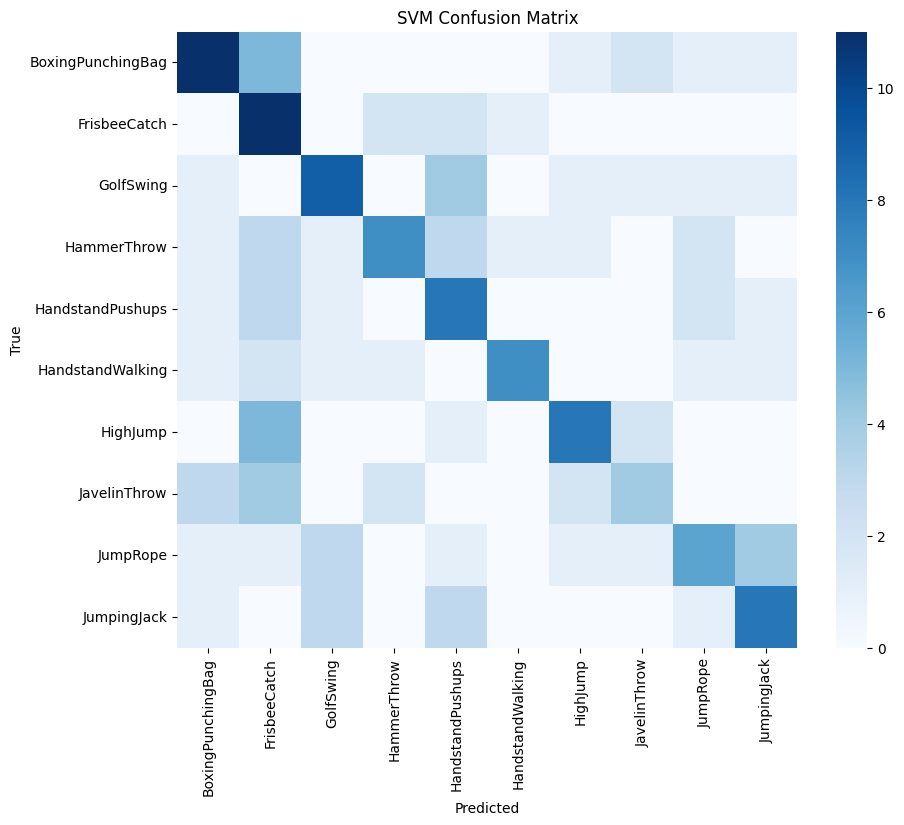

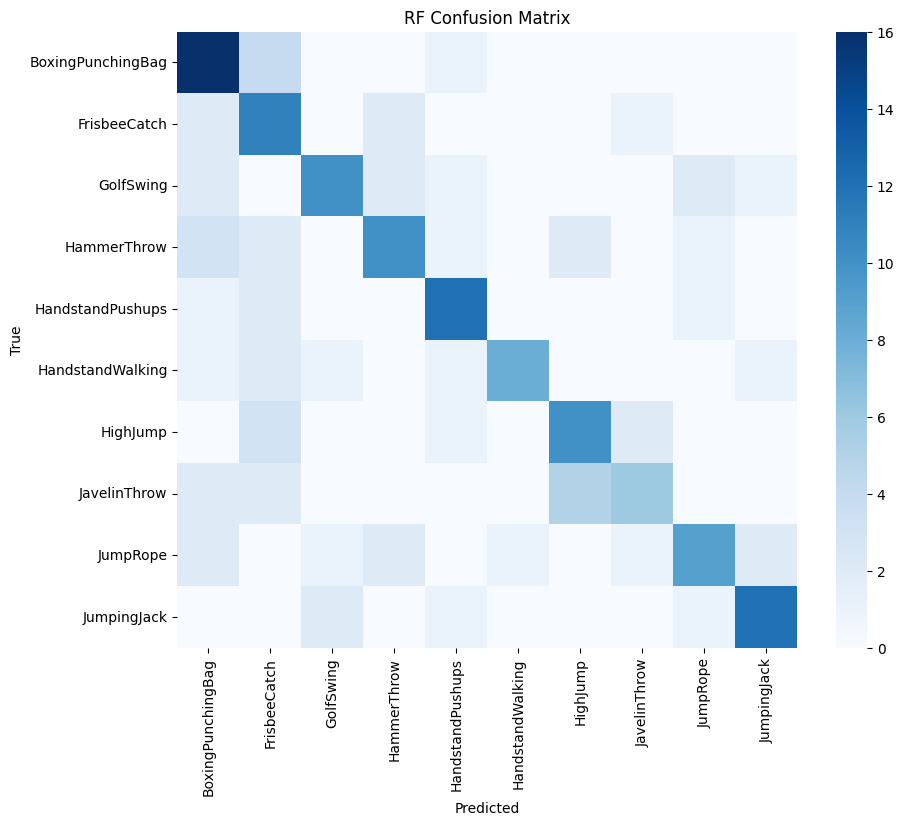

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_predictions(y_true, y_pred, title="Model"):
    print(f"=== {title} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average="macro", zero_division=0))
    print("Recall (macro):", recall_score(y_true, y_pred, average="macro", zero_division=0))
    print("F1 (macro):", f1_score(y_true, y_pred, average="macro", zero_division=0))
    print()
    print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

def plot_cm(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

svm_preds = svm_best.predict(X_test)
rf_preds  = rf_best.predict(X_test)

evaluate_predictions(y_test_enc, svm_preds, "SVM (Classical Features)")
evaluate_predictions(y_test_enc, rf_preds,  "Random Forest (Classical Features)")

plot_cm(y_test_enc, svm_preds, "SVM Confusion Matrix")
plot_cm(y_test_enc, rf_preds,  "RF Confusion Matrix")


## 3) Deep Learning Pipeline (TensorFlow)
We implement an end-to-end deep learning model using frame sequences. For an advanced architecture, we use **TimeDistributed CNN + LSTM**.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_H, IMG_W = 112, 112
MAX_FRAMES = 16
BATCH_SIZE = 8

def extract_frames_rgb(video_path, max_frames=MAX_FRAMES, size=(IMG_H, IMG_W)):
    cap = cv2.VideoCapture(video_path)
    frames=[]
    while len(frames) < max_frames:
        ok, frame = cap.read()
        if not ok:
            break
        frame = cv2.resize(frame, size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()

    if len(frames) == 0:
        frames = [np.zeros((size[0], size[1], 3), dtype=np.uint8)]

    # pad
    while len(frames) < max_frames:
        frames.append(frames[-1].copy())

    frames = np.stack(frames).astype(np.float32) / 255.0
    return frames  # (T,H,W,3)

class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=BATCH_SIZE, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.bs = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df)/self.bs))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_idx = self.indices[idx*self.bs:(idx+1)*self.bs]
        batch = self.df.iloc[batch_idx]
        X = np.stack([extract_frames_rgb(p) for p in batch["clip_path_resolved"]])
        y = le.transform(batch["label"].values)
        y = tf.keras.utils.to_categorical(y, num_classes=len(le.classes_))
        return X, y

train_seq = VideoSequence(train_df_f, shuffle=True)
val_seq   = VideoSequence(val_df_f, shuffle=False)
test_seq  = VideoSequence(test_df_f, shuffle=False)

len(le.classes_)


10

In [ ]:
def build_tdcnn_lstm(num_classes: int):
    inp = layers.Input(shape=(MAX_FRAMES, IMG_H, IMG_W, 3))
    x = layers.TimeDistributed(layers.Conv2D(32, 3, activation="relu"))(inp)
    x = layers.TimeDistributed(layers.MaxPooling2D())(x)
    x = layers.TimeDistributed(layers.Conv2D(64, 3, activation="relu"))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D())(x)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)
    x = layers.LSTM(128)(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inp, out)
    return model

dl_model = build_tdcnn_lstm(num_classes=len(le.classes_))
dl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

dl_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 110, 110,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 55, 55, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 53, 53, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 26, 26, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,498 (466.79 KB)

 Trainable params: 119,498 (466.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy"),
    tf.keras.callbacks.ModelCheckpoint("best_dl_model.keras", save_best_only=True, monitor="val_accuracy")
]

history = dl_model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.1290 - loss: 2.3001

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 156ms/step - accuracy: 0.1289 - loss: 2.3001 - val_accuracy: 0.1576 - val_loss: 2.2951
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.1457 - loss: 2.2947 - val_accuracy: 0.1515 - val_loss: 2.2839
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.1638 - loss: 2.2806 - val_accuracy: 0.1636 - val_loss: 2.2115
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.1904 - loss: 2.2011 - val_accuracy: 0.2303 - val_loss: 2.1117
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.1819 - loss: 2.1349 - val_accuracy: 0.2424 - val_loss: 2.0619
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.2004 - loss: 2.1074 - val_accuracy: 0.2606 - val_loss: 2.0495
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.2189 - loss: 2.0822 - val_accuracy: 0.2242 - val_loss: 2.0528
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.2235 - loss: 2.0473 - val

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step
=== TimeDistributed CNN + LSTM ===
Accuracy: 0.2603550295857988
Precision (macro): 0.1872807486631016
Recall (macro): 0.2382560568086884
F1 (macro): 0.17130284008603663

                   precision    recall  f1-score   support

BoxingPunchingBag       0.17      0.71      0.28        21
     FrisbeeCatch       0.00      0.00      0.00        16
        GolfSwing       0.38      0.72      0.50        18
      HammerThrow       0.32      0.42      0.36        19
 HandstandPushups       0.00      0.00      0.00        16
 HandstandWalking       0.00      0.00      0.00        14
         HighJump       0.67      0.12      0.21        16
     JavelinThrow       0.33      0.40      0.36        15
         JumpRope       0.00      0.00      0.00        18
      JumpingJack       0.00      0.00      0.00        16

         accuracy                           0.26       169
        macro avg       0.19      0.24      0.17       169
     weighted avg   

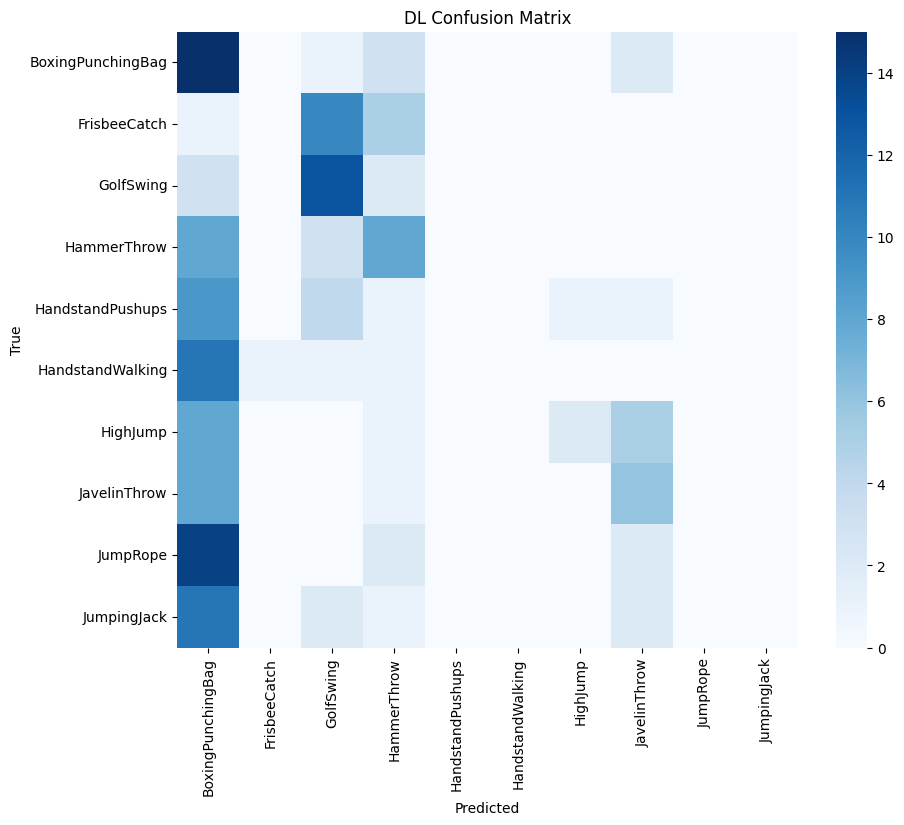

In [ ]:
# Deep Learning Evaluation
dl_model = tf.keras.models.load_model("best_dl_model.keras")

probs = dl_model.predict(test_seq, verbose=1)
dl_preds = probs.argmax(axis=1)

# true labels (encoded) for test_seq in the same order
y_true_dl=[]
for i in range(len(test_seq)):
    _, yb = test_seq[i]
    y_true_dl.append(yb.argmax(axis=1))
y_true_dl = np.concatenate(y_true_dl)

evaluate_predictions(y_true_dl, dl_preds, "TimeDistributed CNN + LSTM")
plot_cm(y_true_dl, dl_preds, "DL Confusion Matrix")


## 4) Final Comparison Table


In [ ]:
def metrics_row(name, y_true, y_pred):
    return {
        "model": name,
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "macro_precision": float(precision_score(y_true, y_pred, average="macro", zero_division=0)),
        "macro_recall": float(recall_score(y_true, y_pred, average="macro", zero_division=0)),
        "macro_f1": float(f1_score(y_true, y_pred, average="macro", zero_division=0)),
    }

rows = [
    metrics_row("SVM (classical features)", y_test_enc, svm_preds),
    metrics_row("Random Forest (classical features)", y_test_enc, rf_preds),
    metrics_row("TD-CNN + LSTM (deep learning)", y_true_dl, dl_preds),
]
results = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
display(results)

results.to_csv("results_comparison.csv", index=False)
print("Saved: results_comparison.csv")


,model,accuracy,macro_precision,macro_recall,macro_f1
1,Random Forest (classical features),0.615385,0.645073,0.612770,0.616033
0,SVM (classical features),0.467456,0.499828,0.467973,0.468628
2,TD-CNN + LSTM (deep learning),0.260355,0.187281,0.238256,0.171303


Saved: results_comparison.csv
